# Problem 1 (20 points)

A major fault in your reservoir has strike N35$^\circ$W and dip 60$^\circ$ from horizontal. $S_{hmin}$ in this area acts along 020$^\circ$, and in situ stresses are $S_{hmin}=70$ MPa, $S_{Hmax}=80$ MPa, $S_v=65$ MPa.   Assume the pore pressure $P_p =30$ MPa. Is the fault likely to slip if the respective frictional coefficient is $\mu=0.7$?

**Solution**

First we'll define some functions that we will use in this problem and the next.

In [1]:
import numpy as np

def compute_Sg(S, angles=(0,0,0)):
    
    alpha, beta, gamma = np.radians(angles)
    
    Rg = np.array([[np.cos(alpha) * np.cos(beta),  
                    np.sin(alpha) * np.cos(beta),  
                    -np.sin(beta)],
                   [np.cos(alpha) * np.sin(beta) * np.sin(gamma) - np.sin(alpha) * np.cos(gamma), 
                    np.sin(alpha) * np.sin(beta) * np.sin(gamma) + np.cos(alpha) * np.cos(gamma),  
                    np.cos(beta) * np.sin(gamma)],
                   [np.cos(alpha) * np.sin(beta) * np.cos(gamma) + np.sin(alpha) * np.sin(gamma), 
                    np.sin(alpha) * np.sin(beta) * np.cos(gamma) - np.cos(alpha) * np.sin(gamma),  
                    np.cos(beta) * np.cos(gamma)]])
                  
    return np.dot(Rg.T, np.dot(S,Rg))


def compute_unit_vectors(strike, dip):
    
    strike = np.radians(strike)
    dip = np.radians(dip)
    
    n = np.array([-np.sin(strike) * np.sin(dip), np.cos(strike) * np.sin(dip), -np.cos(dip) ])
    
    ns = np.array([ np.cos(strike), np.sin(strike), 0 ])
    
    nd = np.array([ -np.sin(strike) * np.cos(dip), np.cos(strike) * np.cos(dip), np.sin(dip) ])
    
    return (n, ns, nd)


def compute_stress_components_on_fault(S, strike, dip, angles=(0,0,0)):

    S_G = compute_Sg(S, angles)
    
    n, ns, nd = compute_unit_vectors(strike, dip)
    
    sigma_n = np.dot(np.dot(S_G, n), n)
    tau_s = np.dot(np.dot(S_G, n), ns)
    tau_d = np.dot(np.dot(S_G, n), nd)
    
    tau_mag = np.sqrt(tau_s ** 2. + tau_d ** 2.)
    
    return (sigma_n, tau_s, tau_d, tau_mag)


def check_fault_slip(S, Pp, strike, dip, angles=(0,0,0), mu=0.6):
    
    sigma_n, tau_s, tau_d, tau_mag = compute_stress_components_on_fault(S, strike, dip, angles)
    
    return (tau_mag / (sigma_n - Pp) > mu)

Now we can check to see if our fault is slipping under the given conditions from the funcions above.

In [2]:
S = np.diag([80, 70, 65])

check_fault_slip(S, 30, 35, 60, angles=(-70,0,0), mu=0.7)

False

# Problem 2 (50 points)

Assuming the same reservior conditions as Problem 1, write a computer code that can compute the resolved shear stress magnitude and normal effective stress on a fault characterized by the strike direction and dip angle.  Now randomly generate 10000 faults (use a statistical distribution to choose random pairs of strike and dip) and plot the results on a Mohr diagram.  Where do near vertical strike-slip faults appear on this diagram? Where do the oblique-slip faults fall?

**Solution**

The code below creates the random faults.  We will assume that a near-vertical strike-slip fault is one in which the dip angle is greater than $85^\circ$.  Oblique-slip faults are those that have near-equal magnitudes of shear and dip components of shear stresses.

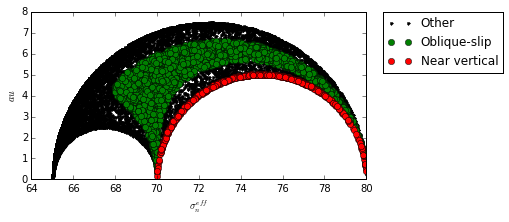

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

def create_plot(S, angles=(0,0,0)):

    strikes = np.random.rand(10000) * 360
    dips =  np.random.rand(10000) * 90

    out = np.array([ compute_stress_components_on_fault(S, strikes[i], dips[i], angles) for i in range(len(strikes)) ])

    normal = out[:,0]
    shear_slip = out[:,1]
    shear_dip = out[:,2]
    shear_mag = out[:,3]


    vert_ss = np.logical_and(dips > 85, np.abs(shear_slip / shear_dip) > 5)
    oblique_slip = np.logical_and(0.75 < np.abs(shear_slip / shear_dip), np.abs(shear_slip / shear_dip) < 1.5)
    other = np.logical_not(np.logical_or(vert_ss, oblique_slip))

    plt.figure()
    plt.gca().set_aspect('equal')
    plt.plot(normal[other], shear_mag[other], 'k.',
             normal[oblique_slip], shear_mag[oblique_slip], 'go',
             normal[vert_ss], shear_mag[vert_ss], 'ro'),
    plt.xlabel('$\sigma_n^{eff}$')
    plt.ylabel('${\tau}$');
    plt.legend(['Other','Oblique-slip', 'Near vertical'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
    
    
create_plot(S, angles=(-70,0,0))

The plot above sort-of speaks for itself, there is no reason to describe in words the answers to the questions with a properly made figure.

# Problem 3 (10 points)

Repeat Problem 2 but make $S_{hmin}=S_{Hmax}=45$ MPa (i.e. stress isotropic in the horizontal plane. How has the Mohr diagram changed? Is this still a 3D problem?

**Solution**

We can use our code above to quickly solve this problem by simply plugging in the new numbers.

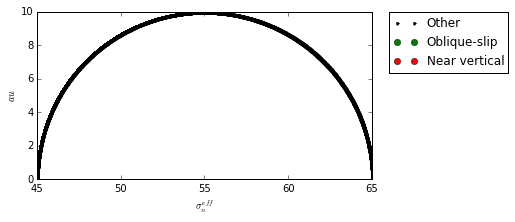

In [63]:
S = np.diag([65, 45, 45])
create_plot(S, angles=(0,-90,0))

This problem is clearly 2D as it can be fully characterized by the two principle stresses.

#Problem 4 (10 points)

a. Using a constitutive model for an isotropic elastic solid that relates strains to applied effective stresses corrected by Biot's coefficient, assume you have a sample in subsurface subjected to overburden, and that confinement in both horizontal principal directions is so large that the horizontal strains are nearly zero. Derive elastic equations for horizontal stresses (use the variables $x$ and $y$ for horizontal directions) in terms of vertical loading as a function of depth (in $z$ direction).

**Solution**

Hooke's law

\begin{align}
\sigma_{xx} = \lambda (\varepsilon_{xx} + \varepsilon_{yy} + \varepsilon_{zz}) + 2 \mu \varepsilon_{xx} \\
\sigma_{yy} = \lambda (\varepsilon_{xx} + \varepsilon_{yy} + \varepsilon_{zz}) + 2 \mu \varepsilon_{yy} \\
\sigma_{zz} = \lambda (\varepsilon_{xx} + \varepsilon_{yy} + \varepsilon_{zz}) + 2 \mu \varepsilon_{zz}
\end{align}

Substituting the assumptions from the problem statement

\begin{align}
\sigma_{H} = \lambda \varepsilon_{v} \\
\sigma_{H} = \lambda \varepsilon_{v}  \\
\sigma_{v} = \lambda \varepsilon_{v} + 2 \mu \varepsilon_{v} = (\lambda + 2 \mu) \varepsilon_v
\end{align}

Solving the third equation for $\varepsilon_{v}$

$$
\varepsilon_v = \frac{\sigma_{v}}{(\lambda + 2 \mu)}
$$

Substituting into one of the others

$$
\sigma_{H} = \frac{\lambda \sigma_{v}}{(\lambda + 2 \mu)} 
$$

and using the relationship 

$$
\lambda = \frac{2 \mu \nu}{1 - 2 \nu}
$$

and simplifying

$$
\sigma_{H} = \frac{\nu \sigma_{v}}{3\nu - 1} = \frac{\nu \bar{\rho}g z}{3\nu - 1}
$$

and using the Biot's effective stress relationship we have:

$$
S_{H} = \frac{\nu (S_{v} - \alpha P_p)}{3\nu - 1}  +  \alpha P_p
$$

b. Assume you are at depth of $4$ km and the pore pressure at that depth is hydrostatic. Using the equations derived in a) above, Biot's parameter of $\alpha=0.7$, and a Poisson’s ratio $\nu=0.2$, estimate the horizontal stress magnitudes $S_{hmin}=S_{Hmax}$ at that depth. 

**Solution**

\begin{align}
S_{H}  &= \frac{0.2 (92 \mbox{ MPa} - 0.7 \cdot 40 \mbox{ MPa})}{3\cdot 0.2 - 1}  +  0.7 \cdot 40 \mbox{ MPa} \\
       &= -4 \mbox{ MPa}
\end{align}

# Problem 5 (30 points)

Bernabe and Brace (1990) in their article "Deformation and fracture of Berea Sandstone" reported a number of triaxial test measurements for Berea sandstone, and some of them are given in the table below (all data in MPa).

|$S_3$ (confining pressure) | $P_p$ (pore pressure) | $S_1-S_3$ (differential stress) |
|---------------------------|-----------------------|---------------------------------|
|10|0|116|
|50|0|227|
|20|8|119|
|45|8|183|
|60|8|206|
|75|8|228|
|50|37|120|
|50|32|141|
|90|64|161|
|90|55|187|
|130|96|186|
|130|84|207|

Fit this data to Mohr-Coulomb criterion to compute unconfined compressive strength $C_0$ and internal friction coefficient $\mu_i$ for Berea sandstone.


**Solution**

First we create a curve fit and then use Eq. 4.5 from the book to find the internal friction and extrapolate $C_0$.

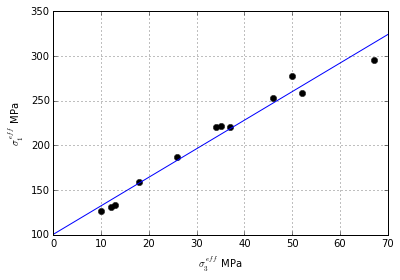

In [80]:
data = np.array([[10, 0, 116], [50, 0, 227], [20, 8, 119], [45, 8, 183], 
                 [60, 8, 206], [75, 8, 228], [50, 37, 120], [50, 32, 141],
                 [90, 64, 161], [90, 55, 187], [130, 96, 186], [130, 84, 207]])

S3_eff = data[:,0] - data[:,1]
S1_eff = data[:,2] + data[:,0] - data[:,1]

z = np.polyfit(S3_eff, S1_eff, 1)

nfun = np.poly1d(z)

line_x = np.linspace(0,70, num=100)
line_y = nfun(line_x)

plt.plot(S3_eff, S1_eff, 'ko', line_x, line_y, 'b-');
plt.grid()
plt.xlabel('$\sigma_3^{eff}$ MPa')
plt.ylabel('$\sigma_1^{eff}$ MPa');

In [75]:
print z[1]

print (z[0] - 1) / 2 / np.sqrt(z[0])

100.080890436
0.614932136531


From the polynomial fit

$C_0 = 100$ MPa

and from the computation above

$\mu_I = 0.61$